In [12]:
import numpy as np
import gc


class MyKMeans:
    """Simple realisation of K-Means algorithm, using 3 methods of initialisation:
    1) 'random' -- cluster centers are initialised with random samples from selection;
    2) 'max_distances' -- first cluster center is initialised with random sample and all the
    others are initialised with the sample that is as remote as possible from previous centers;
    3) 'k-means++' -- quite known algorithm of initialisation, you can
    read about it at https://en.wikipedia.org/wiki/K-means%2B%2B.
    """

    def __init__(self, random_state: int = 0, n_clusters: int = 3, heuristic: str = 'random', max_iter: int = 300):
        self.random_state = random_state

        assert n_clusters > 0, "Parameter 'n_clusters' should be positive"
        self.n_clusters = n_clusters

        assert heuristic in ('random', 'max_distances', 'k-means++'), \
            "Parameter 'heuristic' should be one of ('random', 'max_distances', 'k-means++')"

        self.heuristic = heuristic

        assert max_iter > 0, "Parameter 'max_iter' should be positive"
        self.max_iter = max_iter

        self.n_iters_ = 0
        self.labels_ = np.empty(0)
        self.cluster_centers_ = np.empty(0)
        self.distances_ = np.empty(0)
        self.fit_data_ = 0

    def fit(self, data):
        shape = data.shape[0]
        self.fit_data_ = data
        np.random.seed(self.random_state)
        self.cluster_centers_ = np.zeros(shape=(self.n_clusters, data.shape[1]))
        self.labels_ = np.empty(shape, dtype='int32')
        self.distances_ = np.empty(shape, dtype='int32')
        if self.heuristic == "random":
            # just selecting random samples
            for idx in range(self.n_clusters):
                self.cluster_centers_[idx] = data[np.random.randint(shape, size=1), :]
        elif self.heuristic == 'k-means++':
            self.cluster_centers_[0] = data[np.random.randint(shape, size=1), :]
            distances = np.ndarray(shape)
            for cluster in range(self.n_clusters)[1:]:
                for idx, x in enumerate(data):
                    # assigning every sample the minimum distance from existing centers
                    distances[idx] = np.amin(np.array(list(map(lambda y: np.linalg.norm(y - x),
                                                               self.cluster_centers_[:cluster]))))
                rnd = np.random.random() * sum(distances)
                cum_sum = 0
                center = data[0, :].copy()
                for idx, x in enumerate(data):
                    # searching for the sample, which probability
                    # is proportional to its distance
                    center = x.copy()
                    cum_sum += distances[idx]
                    if cum_sum >= rnd:
                        break
                self.cluster_centers_[cluster] = center
        else:
            # finding samples that are as far as they could be from previous centers
            self.cluster_centers_[0] = data[np.random.randint(shape, size=1), :]
            distances = np.zeros(shape)
            for idx in range(self.n_clusters)[1:]:
                for cluster in range(idx):
                    distances += np.array(list(map(lambda x: np.linalg.norm(x -
                                                                            self.cluster_centers_[cluster]), data)))
                    self.cluster_centers_[idx] = data[distances.argmax(), :]
        while self.n_iters_ < self.max_iter:
            # assigning samples with labels
            for idx, x in enumerate(data):
                tmp = np.array(list(map(lambda y: np.linalg.norm(x - y),
                                        self.cluster_centers_)))
                self.labels_[idx] = tmp.argmin()
                self.distances_[idx] = tmp.min()

            # recomputing the cluster centers
            for cluster in range(self.n_clusters):
                cardinality = sum(self.labels_ == cluster)
                if cardinality != 0:
                    self.cluster_centers_[cluster] = sum(data[self.labels_ == cluster]) / cardinality
            self.n_iters_ += 1
        gc.collect()
        return self

    def predict(self, data):
        if self.fit_data_ is data:
            return self.labels_
        assert len(self.cluster_centers_[0]) == data.shape[1]
        self.labels_ = np.ndarray(data.shape[0])
        for idx, x in enumerate(data):
            self.labels_[idx] = int(np.array(list(map(lambda y: np.linalg.norm(x - y),
                                                      self.cluster_centers_))).argmin())
        gc.collect()
        return self.labels_

    def fit_predict(self, data):
        self.fit(data)
        return self.predict(data)

    def get_params(self):
        return {
            'random_state': self.random_state,
            'n_clusters': self.n_clusters,
            'heuristic': self.heuristic,
            'max_iter': self.max_iter
        }

# Analysis of the implementation
## 1. Comparison with sklearn
So, to start the analysis, I decided to make the most obvious comparison: juxtapose my version of the algorithm and the sklearn one. To do so, I created some simple datasets and visualized the results of both implementations to see the differences. In both algorithms I selected the 'k-means++' initialization.

In [2]:
from sklearn.datasets import make_blobs
# import dataset maker
from sklearn.cluster import KMeans
# import sklearn version of algorithm to compare

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-dark')

import warnings

warnings.filterwarnings("ignore")

On the graphics below the result of the comparison is presented. Different clusters are represented with different colors, and the contrasting dots are cluster centers. As you can see, the output of two algorithms is quite similar: on first dataset the results are nearly identical, on the third one difference is seen in only few dots. A bit dissimilar scenario is observed on the second dataset: the two top left clusters are identified differently by two algorithms.

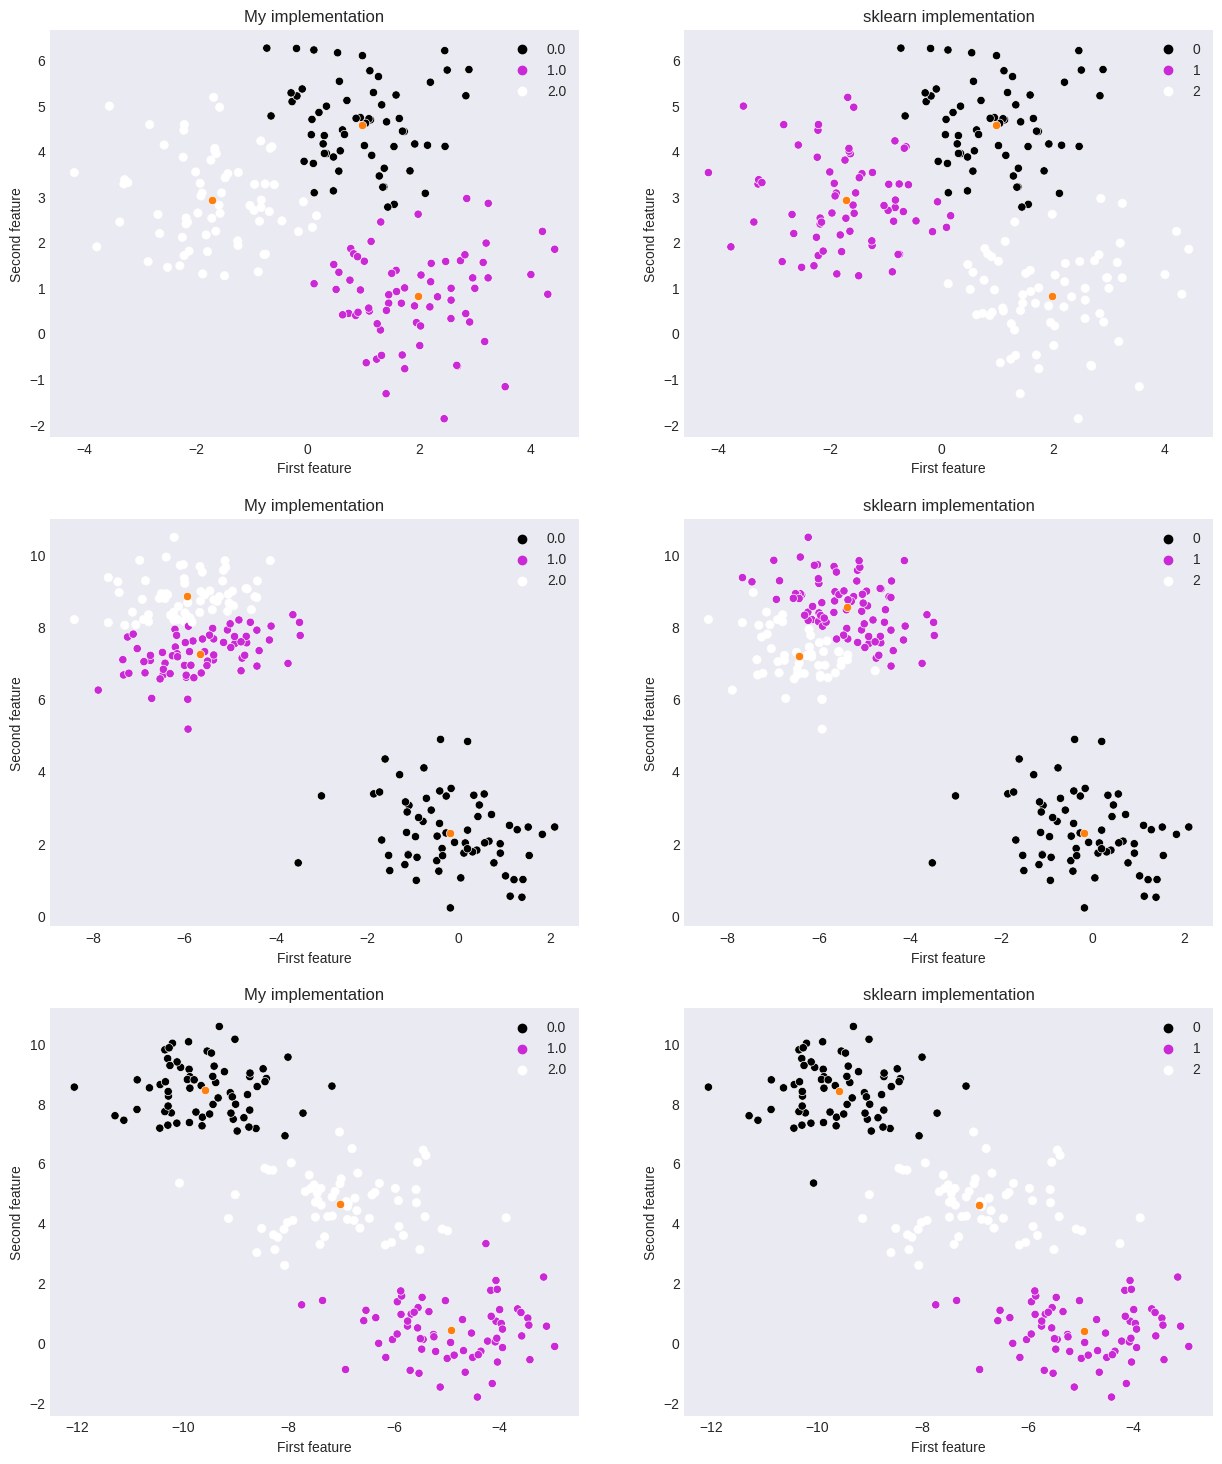

In [3]:
# comparing the results of realisations of k-means
# on different datasets, using 'k-means++' initialisation
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
for row, sample_seed in enumerate([0, 5, 12]):
    X, y = make_blobs(n_samples=200, n_features=2, centers=3, random_state=sample_seed)
    a = MyKMeans(n_clusters=3, random_state=0, heuristic='k-means++').fit(X)
    b = KMeans(n_clusters=3, random_state=0, init='k-means++').fit(X)
    for column, implementation in enumerate([(a, "My implementation"), (b, "sklearn implementation")]):
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=implementation[0].predict(X), palette='gnuplot2',
                        ax=ax[row, column])
        ax[row, column].set_xlabel("First feature")
        ax[row, column].set_ylabel("Second feature")
        # marking cluster centers
        sns.scatterplot(x=implementation[0].cluster_centers_[:, 0],
                        y=implementation[0].cluster_centers_[:, 1], ax=ax[row, column], palette='gnuplot2')
        ax[row, column].set_title(implementation[1])
plt.show()

Let's research the second dataset situation more closely. We will look at the centers of the clusters provided by the make_blobs function and compare them with the cluster centers returned by k-means algorithms. On the plot below, generated centers are marked in green, and centers produced by the algorithms are marked in orange.

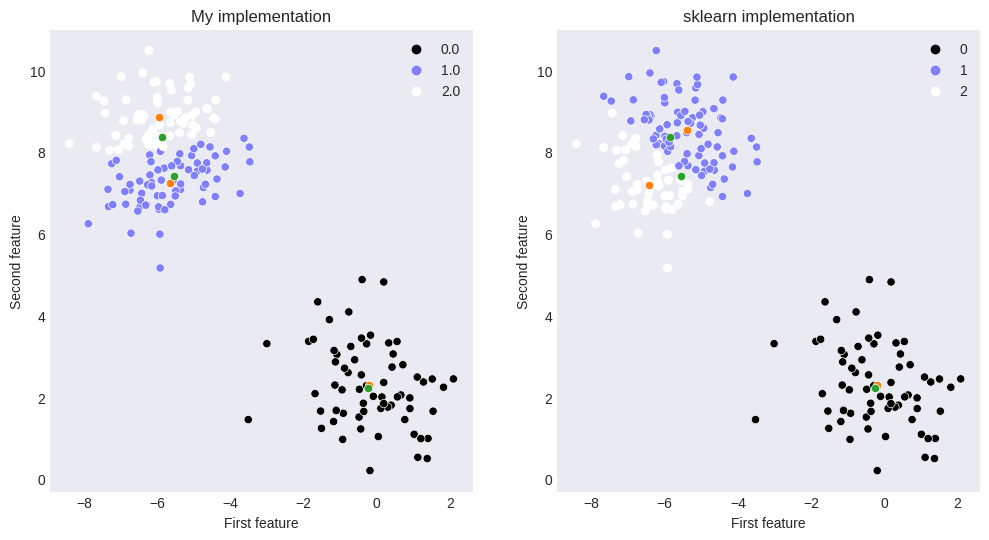

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
X, y, actual_centers = make_blobs(n_samples=200, n_features=2, centers=3, random_state=5, return_centers=True)
a = MyKMeans(n_clusters=3, random_state=0, heuristic='k-means++').fit(X)
b = KMeans(n_clusters=3, random_state=0, init='k-means++').fit(X)
for column, implementation in enumerate([(a, "My implementation"), (b, "sklearn implementation")]):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=implementation[0].predict(X), palette='gist_stern', ax=ax[column])
    # i chose this palette to contrast the centers

    ax[column].set_xlabel("First feature")
    ax[column].set_ylabel("Second feature")

    sns.scatterplot(x=implementation[0].cluster_centers_[:, 0],
                    y=implementation[0].cluster_centers_[:, 1], ax=ax[column])
    sns.scatterplot(x=actual_centers[:, 0], y=actual_centers[:, 1], ax=ax[column], palette="gist_stern")
    ax[column].set_title(implementation[1])
plt.show()

As we can see, "hand-made" k-means produced cluster centers that are much closer to the original centers, used in the generation of dataset.

## 2. Distance matrices and their sorting techniques
The next step of our analysis would be the distance matrices and different approaches to their sorting. We will examine these approaches on the same exact datasets as in the previous iteration of analysis, and for each dataset we will build three distant matrices: the one that isn't sorted, the one sorted by label and, at last, the one that is sorted by label and then by distance from the corresponding center. I chose this method because it is obvious, explainable and easy-to-implement.

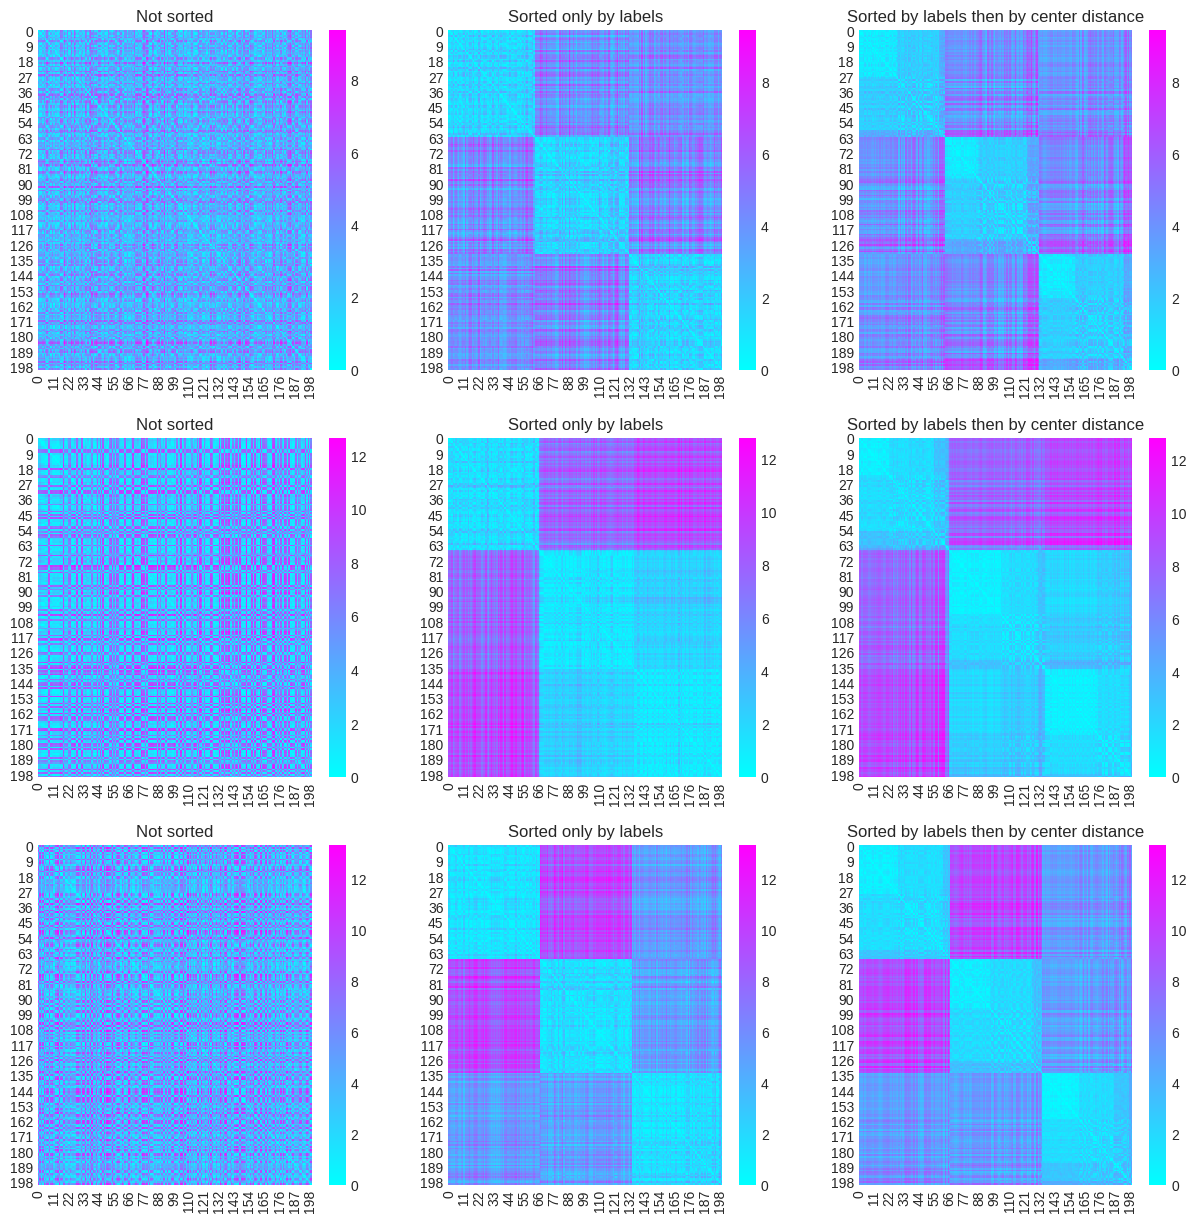

In [5]:
# sorting the distance matrices by sample labels then by center distances
from scipy.spatial.distance import pdist, squareform

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for row, sample_seed in enumerate([0, 5, 12]):
    X, y = make_blobs(n_samples=200, n_features=2, centers=3, random_state=sample_seed)
    a = MyKMeans(n_clusters=3, random_state=0, heuristic='k-means++').fit(X)
    dist_matrices = [
        squareform(pdist(X)),
        # not sorted matrix

        squareform(pdist(sorted(np.insert(X, X.shape[1], a.labels_, axis=1), key=lambda x: x[-1]))),
        # matrix sorted by label

        squareform(pdist(sorted(np.insert(X, X.shape[1], (a.labels_, a.distances_), axis=1),
                                key=lambda x: (x[-2], x[-1]))))
        # matrix sorted by label then by distance from center
    ]
    for column, matrix in enumerate(dist_matrices):
        sns.heatmap(matrix, cmap="cool", ax=ax[row, column])
    for column, string in enumerate(["Not sorted", "Sorted only by labels",
                                     "Sorted by labels then by center distance"]):
        ax[row, column].set_title(string)
plt.show()

We, again, can observe non-ordinary situation with the second dataset, which is, once again, is caused by the proximity of two clusters compared to the third one.

# 3. Estimating the algorithm complexity and analysing the connection between speed and data complexity
We will look how much slower the algorithm will work when the volume and complexity of data increases. At first, we will use datasets generated in the same way as before, but with greater amount of data. We will also see how the execution time of the algorithm depends on the initialization method.

In [ ]:
for n_samples in [100, 500, 1500, 10000]:
    for n_features in [2, 5, 10, 20]:
        for heuristic in ['random', 'max_distances', 'k-means++']:
            print(f'Dataset with shape ({n_samples}, {n_features}). '
                  f'Algorithm configuration with {heuristic} initialization time:')
            X, y = make_blobs(n_samples, n_features, random_state=13)
            %timeit a = MyKMeans(heuristic=heuristic).fit_predict(X)